In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directoryd
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import plotly.express as px
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#tracking_2018 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2018.csv')
#tracking_2019 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2019.csv')
tracking_2020 = pd.read_csv('../input/nfl-big-data-bowl-2022/tracking2020.csv')
#years = [tracking_2018, tracking_2019, tracking_2020]
#tracking = pd.concat(years)
#plays    = pd.read_csv('../input/nfl-big-data-bowl-2022/plays.csv')
#players = pd.read_csv('../input/nfl-big-data-bowl-2022/players.csv')

# Introduction

Looking beyond the nuances of strategy and analytics, a punt return is a fairly simple play; a returner catches a ball and looks to run as far forward as he can through a sea of players trying to stop him, all while being shepherded by his teammates. While speed and agility are essential aspects to a great return, the elegance of punt return play truly comes from the returner’s countless, instinctual split-second decisions that weave him through the chaos. Rather than quantifying physical aspects of the game or looking at play outcomes holistically, we looked to isolate one of the true essences of football: the instantaneous decisions ball-carriers have honed through years of play to win yards for their team. 

In our analysis, we quantified the accuracy of punt returners’ instantaneous decision-making to allow for critical examination of a returner’s decisions throughout a single play and to develop a custom analytic, Decisional Cognition (DC), to assess the accuracy of different returner’s decisions throughout the season. In order to do this, we first built an expected yards model (xY) to return the yards a returner should yield with their return at any given moment, based on the movements and positions of themselves and defensive players. Using this model as a function, we isolated the instantaneous decisions returners made on any given punt return, and rated their accuracy. From this, we build DC, an integrated metric that rates returners’ decision-making abilities.



Source Code: https://github.com/AskSid/Big-Data-Bowl-2022-Submission.git 

# Data Processing
## Plays Included
In order to create an expected yards model that works for any point in the play, we decided to analyze punt plays which were returned for any yardage. This excludes touchbacks, fair catches, and muffed punts. All tracking data for the football itself was ignored as it would align with the returner's position. For each punt play, we decided to include every frame from the moment the punt was received until the returner either stepped out of bounds, was tackled, or fumbled the ball.

## Feature Engineering
Due to the direction of plays differing (right vs. left), all x, orientation, and direction of motion values were standardized to be facing the same direction. In order to standardize the data, the corresponding yardage remaining of each frame was calculated to be the difference between the current x value and the starting x value of the returner at the catch, subtracted from the total yardage gained on the play.
* yardage_remaining = total_yardage - (returner_start_x - current_x)

The key feature we generated was an insight from this 2019 notebook (https://www.kaggle.com/cpmpml/graph-transfomer), the distance matrix. A 22 by 22 matrix was constructed with each cell being the relative distance between two players on the field. This matrix helps the model understand how each player interacts with one another during a play, and their relation to the returner. 

# Expected Yards Model
There were two inputs provided to the model: 
1. Returner Data (speed, acceleration, orientation, direction of motion)
2. Distance Matrix (22 x 22)

A neural network with 3 dense layers was used for the returner data, while the distance matrix had a convolutional layer due to its structure along with five dense layers. The outputs of each independent model were then concatenated and put in a final dense layer. The final output was a linear regression activation which produces the expected yards for a given frame of a single play. 

The model was trained and tested solely on 2018 and 2019, with a 75/25 split. The test accuracy finished at a mean squared error value of 29.562. The model wasn't tested on 2020 data due to inconsistencies with return yards on penalized plays leading to a much larger mean squared error. This expected yards model can be used to evaluate the success of the returning team as a play progresses, but our main focus was applying this model to analyze a single variable, direction of motion.

# Analyzing Direction of Motion
In order to isolate how a returner individually affects expected yards, we looked at the direction of motion (the angle at which the returner was moving at the time of the frame). An angle of 90 degrees corresponds to moving forwards towards the end zone, while 270 degrees corresponds to directly backwards. Our key insight was that a punt returner's decision at any given instant is merely their direction of motion, or acceleration direction. To see how a given punt returner made a decision at various moments in a play, we calculated the expected yards gained at every possible direction in a frame of a play. By changing only the direction of motion of the returner and passing along the rest of the data unchanged, we were able to evaluate a returner's split-second decision through the expected yards model. 

In the punt below, at frame 192 we analyzed the punt returner's decision making. By modeling expected yards, we obtained the following line plot showing direction of movement vs. predicted yardage gained. The returner made the correct decision in this instance to continue moving slightly left at about 95 degrees in order to score a touchdown. We created a metric Decisional Cognition (DC), which corresponds to the accuracy of a decision. A score closer to 0 indicates a strong decision, while a score closer to 1 indicates a poor decision. A DC score can be calculated for a given instant, play, game, season of a single player. This play resulted in a DC score of 0.027503866688213727, indicating that the returner made an accurate decision, which the data supports. The line plot below shows the distribution of expected yardage for the angle of motion on this play. The red line shows the angle of motion that maximizes the returner’s expected yards, while the blue line shows the returner’s actual decision. These values are obviously pretty close to each other, hence the low DC value. 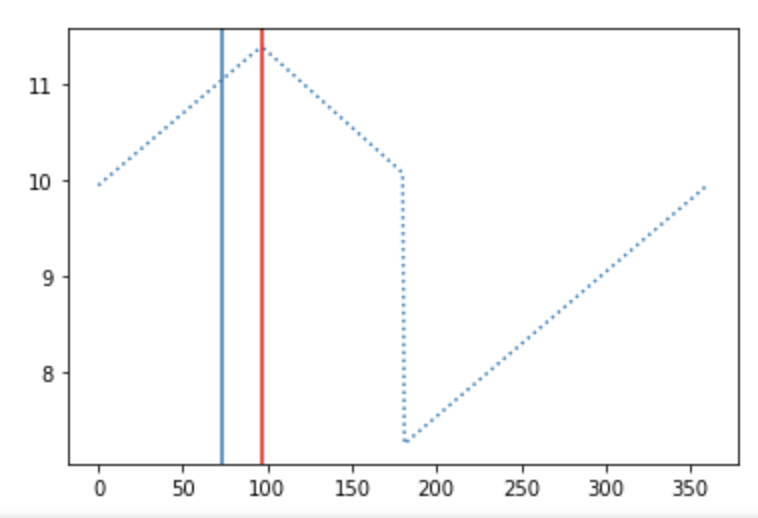

In [ ]:
play = tracking_2020[tracking_2020.gameId == 2020092007]
play = play[play.playId == 1589]

fig = px.scatter(play, x="x", y="y", animation_frame="frameId", color="team")
fig.update_xaxes(range=[0,120])
fig.update_yaxes(range=[0, 53.3])
fig.show()

# Application

## As a coaching tool:
Using our acceleration - xY function, we analyze every single decision made on a return, good and bad. Coaches can look at a returner’s decisions as they compare to the model’s ideal decisions after any game or play in order to give advice to improve decisions in the future. For example, a returner may consistently underperform their expected yards on punt returns in a game, because he is choosing to cut too much, or not enough. With our model, these decisional inaccuracies are very clear, and returners’ ability to make their way through traffic can be tangibly improved by seeing their mistakes (which coaches and players may not have even realized are mistakes without our model).

## As a recruitment tool:
Our model isolates player decision-making. Looking at returners’ DC stat allows for direct comparison between returners’ ability isolated from the strength of their team or opponents. Unlike a standard expected yards model (like the one we developed to serve as a base for our analysis), our Decisional Cognition metric doesn’t factor in the competency of blockers. As such, not only will a team looking for a returner in the market being able to find a pick undervalued by a team that simply looks at a player’s average return yards, but a team using our DC metric would also outcompete teams in the marketplace that evaluate players using expected yard overperformance. Our Decision Cognition metric is a very powerful tool for player valuation because it demonstrates the merits of a returner in any team, strong or weak.

# Future Analysis
Primarily, we were unable to create complete player rankings due to processing limitations of our computers. Even with some run-time optimization, the sheer volume of data required created time and storage problems that prevented us from finding the DC stat for every returner in the NFL and ranking them accordingly. In the future, with greater processing power (a slightly better computer), this shouldn’t be a problem and it'll be fairly simple to generate rankings for all returners in the NFL.

Beyond this simple area of work, we hope to look at this decision-making model in an open-field context. The same split-second decisions punt returners make are also made on any single running play, or by a receiver who’s caught the football. We feel that we’ve developed a powerful insight that can be used in almost any context in the sport, beyond just punt plays.